# Adapting for batch effects when control sample is included, no assumptions on balancing

This is the first of several domain adaptation methods to remove batch effects when it's assumed that batch effects manifest as a simple shift. We do not assume any kind of balancing in the different batches, we might be faced with a situation where all the individuals in a batch are from one group of scientific interest while the other batch are a separate group. However, we do assume that there is a single control sample included among the data. We derive a way for performing domain adaptation using the control sample as \textit{shrunk} subtracting off the control sample.

## First imports

In [1]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

Let us assume the following generative mechanism. We have $I$ batches and within each batch we have $J_i$ individuals. We then generate $X_{ij}$, our observed covariates as follows:
\begin{equation}
\begin{split}
\theta_i &\sim N(0, \sigma_\theta^2)\\
\epsilon_{ij} &\sim N(0, \sigma_\epsilon^2)\\
\delta_{ij} &\sim N(0, \sigma_\delta^2)\\
X_{ij}&=\delta_{ij} +\epsilon_{ij} + \theta_i\\
X_{i1}&=\epsilon_{i1}+\theta_i
\end{split}
\end{equation}
Here, $\theta_i$ represents the batch effect, $\epsilon_{ij}$ represents the observation error, and $\delta_{ij}$ is the signal we are trying to estimate (for example, if each individual either has cancer or doesn't have cancer, we expect $\delta_{ij}$ to differ systematically between the individuals with cancer.

Normally, we would be unable to estimate $\theta_i$ with any sort of confidence due to the small sample sizes in each of the batches. However, we possess one extra piece of knowledge, the very first sample is a control sample added to each of these batches. If $\sigma_\epsilon^2=0$ (no measurement noise), accounting for batch effects is very simple, we simply subtract off the value of the control sample from each of the batches and move on with our lives. Our estimate of $\hat{\delta}_{ij}=X_{ij}$ absent additional information and we can compare whatever groups we want, discover systematic differences between the groups, and fame and fortune are ours.

However, $\sigma_\epsilon^2\ne 0$ in any reasonable dataset. As you will see, this means that subtracting off the control sample is \textit{not} the optimal way to go. In fact, we will instead subtract off $w_iX_{i1}$ where $w_i\in[0,1]$ depends on $\sigma_\delta^2$ and 

## Generate data from this mechanism

Obviously this is not needed when you're analyzing real data, but for now we're demonstrating our method on synthetic data with a known truth set. For now, we assume our proteomics analysis includes a single covariate.

In [2]:
def simulate_single_covariate(n_batches=30, n_samples=15, seed=2022,
                              sigma_d=1.0, sigma_theta=1.0, sigma_epsilon=1.0):
    """
    Simulate data with a single covariate, batch effect, and measurement noise.

    This function generates simulated data based on a hierarchical model where
    each batch has a unique batch effect, and each sample within a batch is
    subject to both measurement error and signal noise. The goal is to estimate
    the true signal (`delta_ij`) by accounting for batch effects (`theta_i`) and
    measurement error (`epsilon_ij`).

    Parameters
    ----------
    n_batches : int, default=30
        The number of batches. Each batch is assumed to have a distinct batch effect.
    
    n_samples : int, default=15
        The number of samples per batch.

    seed : int, default=2021
        Seed for the random number generator to ensure reproducibility.

    sigma_d : float, default=1.0
        Standard deviation of the true signal (`delta_ij`), which represents the
        underlying data that we are trying to estimate.

    sigma_theta : float, default=1.0
        Standard deviation of the batch effects (`theta_i`), which represent
        variability across different batches.

    sigma_epsilon : float, default=1.0
        Standard deviation of the measurement error (`epsilon_ij`), which adds noise
        to each sample measurement.

    Returns
    -------
    theta_list : ndarray of shape (n_batches,)
        The batch effects for each of the `n_batches`.

    control_list : ndarray of shape (n_batches,)
        Control values for each batch, which are the sum of batch effects (`theta_i`)
        and random measurement error.

    data_list : list of ndarray of shape (n_samples,)
        A list containing the simulated data for each batch. Each entry in the list
        corresponds to one batch, and each batch has `n_samples`.

    delta_list : list of ndarray of shape (n_samples,)
        A list of the true signal values (`delta_ij`) for each batch. Each entry in
        the list corresponds to one batch, and each batch has `n_samples`.

    Notes
    -----
    The model follows the structure:
    
    - Batch effect: `theta_i ~ N(0, sigma_theta^2)`
    - Measurement error: `epsilon_ij ~ N(0, sigma_epsilon^2)`
    - True signal: `delta_ij ~ N(0, sigma_d^2)`
    - Observed data: `data_ij = delta_ij + epsilon_ij + theta_i`

    """
    rng = np.random.default_rng(seed)
    theta_list = sigma_theta * rng.normal(size=n_batches)
    control_list = sigma_epsilon * rng.normal(size=n_batches) + theta_list
    data_list = []
    delta_list = []
    for i in range(n_batches):
        delta = rng.normal(size=n_samples)
        delta_list.append(delta)
        data = delta + sigma_d * rng.normal(size=n_samples) + theta_list[i]
        data_list.append(data)
    
    return theta_list, control_list, data_list, delta_list


### Misc plotting methods

Don't worry about these for now

In [16]:
def get_mse_min_point(observed_mse, weight_list):
    min_mse_index = np.argmin(observed_mse)
    min_mse = observed_mse[min_mse_index]
    min_weight = weight_list[min_mse_index]
    return min_weight,min_mse

def plot_mse_with_min_point(observed_mse, weight_list):
    """
    Plots the relationship between weight and observed mean squared error (MSE) 
    with a point marking the minimum MSE and the corresponding weight.

    Parameters
    ----------
    observed_mse : array-like
        A list or array containing the observed MSE values.

    weight_list : array-like
        A list or array containing the weight values corresponding to each MSE.

    Returns
    -------
    None
        The function generates and displays a plot.
    """
    # Find the minimum MSE and its corresponding weight using numpy
    min_weight,min_mse = get_mse_min_point(observed_mse, weight_list)

    # Create a plot with additional customizations
    plt.figure(figsize=(8, 6))
    plt.plot(weight_list, observed_mse, color='teal', linewidth=2.5)

    # Plot the point where observed MSE is minimized
    plt.scatter(min_weight, min_mse, color='red', s=100, zorder=5)
    plt.text(min_weight, min_mse, f'({min_weight:.2f}, {min_mse:.2f})', fontsize=12, fontweight='bold',
             ha='right', color='red', zorder=6)

    # Customizing labels and title
    plt.xlabel('Weight', fontsize=14, fontweight='bold')
    plt.ylabel('Mean Squared Error', fontsize=14, fontweight='bold')
    plt.title('Effect of Shrinkage on Adaptation', fontsize=16, fontweight='bold')

    # Grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Customize the axes ticks and borders
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    # Adjust the thickness of the bottom and left borders
    ax = plt.gca()
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    # Remove the top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the plot
    plt.show()

    
def plot_side_by_side(delta_vals, delta_optimal_weights, delta_optimal_mse):
    """
    Creates two side-by-side plots. The left plot shows the optimal weights vs. sigma^2,
    and the right plot shows the optimal MSE vs. sigma^2.

    Parameters
    ----------
    delta_vals : array-like
        A list or array containing the values of sigma^2.

    delta_optimal_weights : array-like
        A list or array containing the optimal weights corresponding to each sigma^2.

    delta_optimal_mse : array-like
        A list or array containing the optimal MSE corresponding to each sigma^2.


    Returns
    -------
    None
        The function generates and displays the plots side by side.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Left plot: Optimal weights vs. sigma^2
    ax1.plot(delta_vals, delta_optimal_weights, color='teal', linewidth=2.5)
    ax1.set_xlabel(r'$\sigma^2$', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Optimal w', fontsize=14, fontweight='bold')
    ax1.set_title('Optimal Weights', fontsize=16, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Customize axes for the left plot
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Right plot: Optimal MSE vs. sigma^2
    ax2.plot(delta_vals, delta_optimal_mse, color='purple', linewidth=2.5)
    ax2.set_xlabel(r'$\sigma^2$', fontsize=14, fontweight='bold')
    ax2.set_ylabel('MSE', fontsize=14, fontweight='bold')
    ax2.set_title('Optimal MSE', fontsize=16, fontweight='bold')
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Customize axes for the right plot
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.spines['left'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


## Evaluating different domain adaptation schemes

In real life, we won't have 300 batches each with 150 samples (otherwise we would use other methods). However, I want this dataset to be large so that we can accurately measure the performance, which would not be possible under the "realistic" datasets.

In [4]:
sigma_d=1.0,
sigma_theta=1.0
sigma_epsilon=1.0
n_batches=300
n_samples=150

theta_list,control_list,data_list,delta_list = simulate_single_covariate(n_batches=n_batches,
                                                                         n_samples=n_samples,
                                                                         sigma_d=sigma_d,
                                                                         sigma_theta=sigma_theta,
                                                                         sigma_epsilon=sigma_epsilon)

### Performance: no adaptation

We first show what happens when we ignore the batch effects and estimate $\delta$. The natural estimator is $X$, that is the raw value itself. However, we expect the MSE = $\sqrt{\sigma_\theta^2+\sigma_\epsilon^2}$.

In [5]:
X_stack = np.concatenate(data_list)
delta_stack = np.concatenate(delta_list)
print('Observed MSE=',np.sqrt(np.mean((X_stack-delta_stack)**2)))
print('Expected MSE=',np.sqrt(sigma_epsilon**2+sigma_theta**2))


Observed MSE= 1.4394035296044285
Expected MSE= 1.4142135623730951


### Performance: subtract off the control value

Then we show what happens when we use $X_{i1}$ as an estimate of $\theta_i$ and remove it. In this case we expect the mse to be MSE = $\sqrt{2\sigma_\epsilon^2}$

In [6]:
X_naive = np.concatenate([data_list[i] - control_list[i] for i in range(n_batches)])
print('Observed MSE=',np.sqrt(np.mean((X_naive-delta_stack)**2)))
print('Expected MSE=',np.sqrt(2*sigma_epsilon**2))

Observed MSE= 1.355567395483882
Expected MSE= 1.4142135623730951


It looks like we didn't achieve much since we have the same mse as the naive estimate I criticized. However, if $\sigma_\theta^2\gg \sigma_\epsilon^2$ this will be a dramatic improvement. Basically if the batch effects are dominant this can give dramatic improvements (but will make life worse if there are no batch effects.

### Performance: subtract off a shrunk control value

I claimed above that we would be better off subtracting off a weighted control value rather than the observed control value would be optimal. Before deriving that fact, I will show this emprically. I will evaluate the MSE as a function of $w$, with our estimate of $\delta_{ij}=X_{ij}-w X_{i1}$.



In [7]:
n_weights = 1000
weight_list = np.linspace(0,1,n_weights)
observed_mse = np.zeros(n_weights)
for j in range(n_weights):
    X_weighted = np.concatenate([data_list[i] - weight_list[j]*control_list[i] for i in range(n_batches)])
    observed_mse[j] = np.sqrt(np.mean((X_weighted-delta_stack)**2))


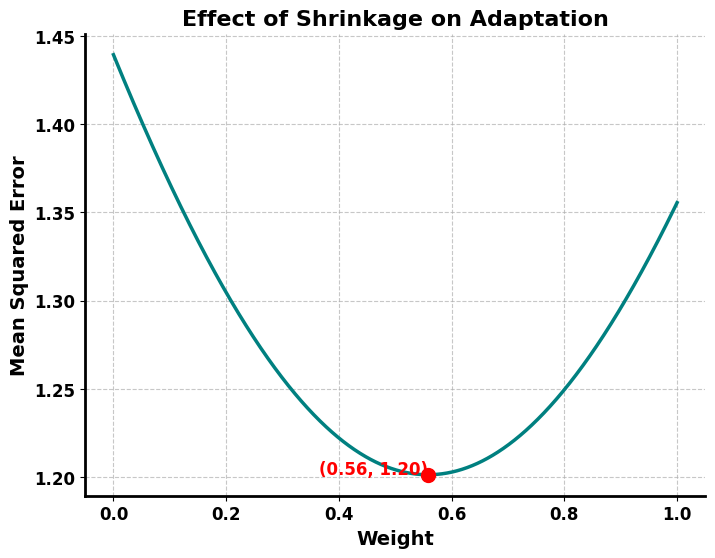

In [8]:
# Example usage with dummy data
plot_mse_with_min_point(observed_mse, weight_list)

As we can see, both the naive and no adaptation cases are dramatically worse than using a shrunk value. It's actually quite surprising. In fact the minimum is obtained as $1/2$ and the MSE is $1.21$ as opposed to $\sqrt{2}$ for either approach. So the question is, what is this optimal weight and MSE depending on $\sigma_\epsilon^2$, $\sigma_\delta^2$ and $\sigma_\theta^2$. Let's plot a few values and find out.

## Effect of $\sigma_\delta^2$

In [9]:
def get_weight(theta_list,control_list,data_list,delta_list):
    n_weights = 1000
    X_stack = np.concatenate(data_list)
    delta_stack = np.concatenate(delta_list)
    weight_list = np.linspace(0,1,n_weights)
    observed_mse = np.zeros(n_weights)
    for j in range(n_weights):
        X_weighted = np.concatenate([data_list[i] - weight_list[j]*control_list[i] for i in range(len(delta_list))])
        observed_mse[j] = np.sqrt(np.mean((X_weighted-delta_stack)**2))
    return weight_list,observed_mse

In [10]:
n_delta = 100

delta_vals = np.linspace(.5,1.5,n_delta)
delta_optimal_weights = np.zeros(n_delta)
delta_optimal_mse = np.zeros(n_delta)

for i in trange(n_delta):
    theta_list,control_list,data_list,delta_list = simulate_single_covariate(n_batches=n_batches,
                                                                         n_samples=n_samples,
                                                                         seed=2020+i,
                                                                         sigma_d=delta_vals[i],
                                                                         sigma_theta=1.0,
                                                                         sigma_epsilon=1.0)
    weight_list,observed_mse = get_weight(theta_list,control_list,data_list,delta_list)
    min_weight,min_mse = get_mse_min_point(observed_mse,weight_list)
    delta_optimal_weights[i] = min_weight
    delta_optimal_mse[i] = min_mse


100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


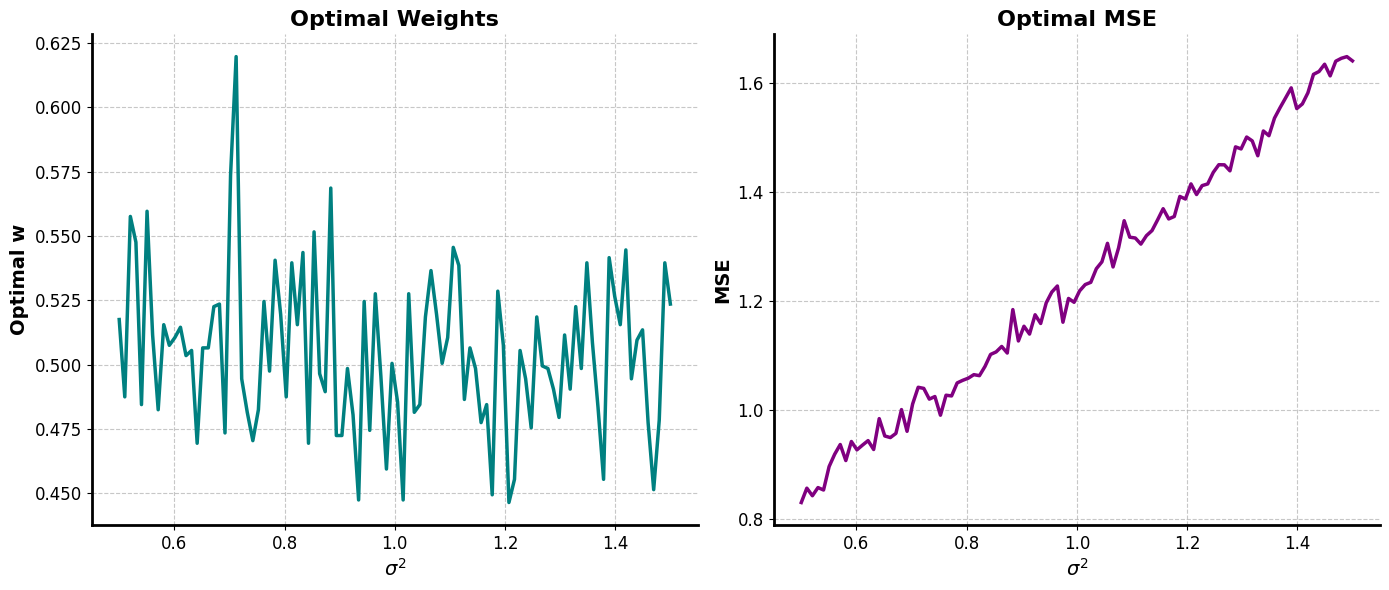

In [17]:
plot_side_by_side(delta_vals, delta_optimal_weights, delta_optimal_mse)


So basically the noise in delta has no impact on what the optimal weighting is, just how much our error is on estimating the true effect. So in one sense, this is our irreducible noise from this perspective

## Effect of $\sigma_\epsilon^2$

Now we're looking at our observation error

In [18]:
n_epsilon = 100

epsilon_vals = np.linspace(.5,1.5,n_epsilon)
epsilon_optimal_weights = np.zeros(n_epsilon)
epsilon_optimal_mse = np.zeros(n_epsilon)

for i in trange(n_epsilon):
    theta_list,control_list,data_list,delta_list = simulate_single_covariate(n_batches=n_batches,
                                                                         n_samples=n_samples,
                                                                         seed=2020+i,
                                                                         sigma_d=1.0,
                                                                         sigma_theta=1.0,
                                                                         sigma_epsilon=epsilon_vals[i])
    weight_list,observed_mse = get_weight(theta_list,control_list,data_list,delta_list)
    min_weight,min_mse = get_mse_min_point(observed_mse,weight_list)
    epsilon_optimal_weights[i] = min_weight
    epsilon_optimal_mse[i] = min_mse


100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


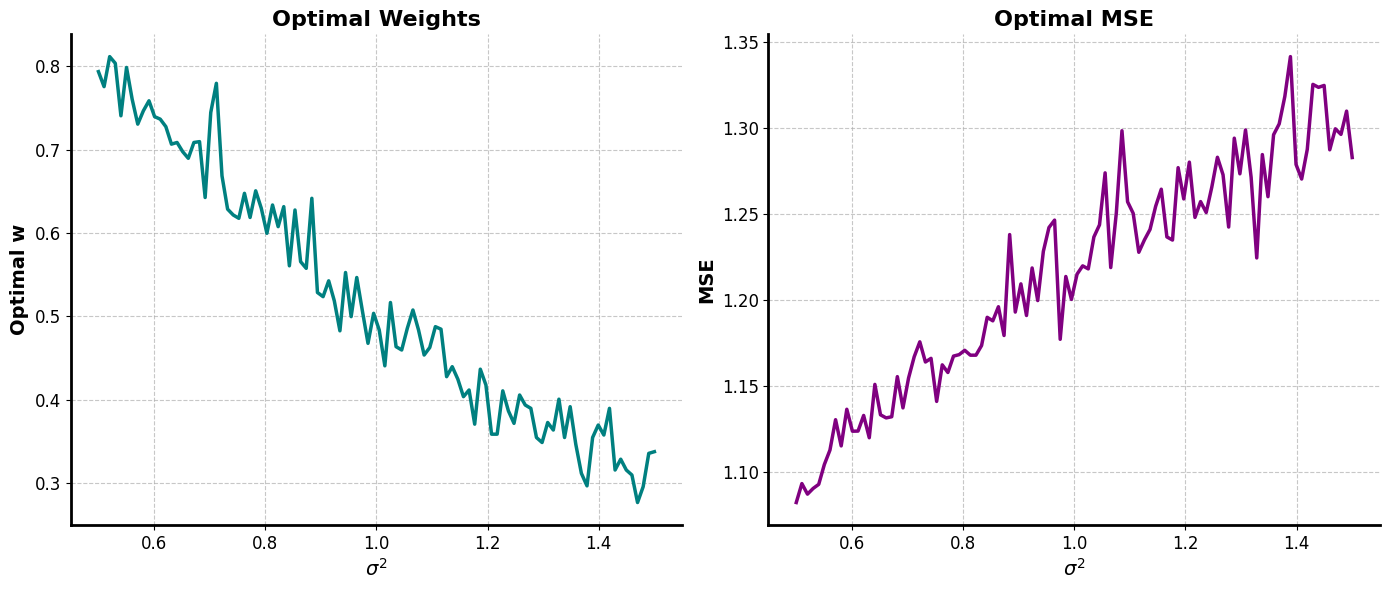

In [19]:
plot_side_by_side(epsilon_vals, epsilon_optimal_weights, epsilon_optimal_mse)


So as our measurement noise increases, the amount we should adjust using the control samples drops. This is unsurprising, as these single samples are less informative.

## Effect of $\sigma_\theta^2$

Now we're looking at our batch effect sizes

In [20]:
n_theta = 100

theta_vals = np.linspace(.5,1.5,n_theta)
theta_optimal_weights = np.zeros(n_theta)
theta_optimal_mse = np.zeros(n_theta)

for i in trange(n_epsilon):
    theta_list,control_list,data_list,delta_list = simulate_single_covariate(n_batches=n_batches,
                                                                         n_samples=n_samples,
                                                                         seed=2020+i,
                                                                         sigma_d=1.0,
                                                                         sigma_theta=theta_vals[i],
                                                                         sigma_epsilon=1.0)
    weight_list,observed_mse = get_weight(theta_list,control_list,data_list,delta_list)
    min_weight,min_mse = get_mse_min_point(observed_mse,weight_list)
    theta_optimal_weights[i] = min_weight
    theta_optimal_mse[i] = min_mse


100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


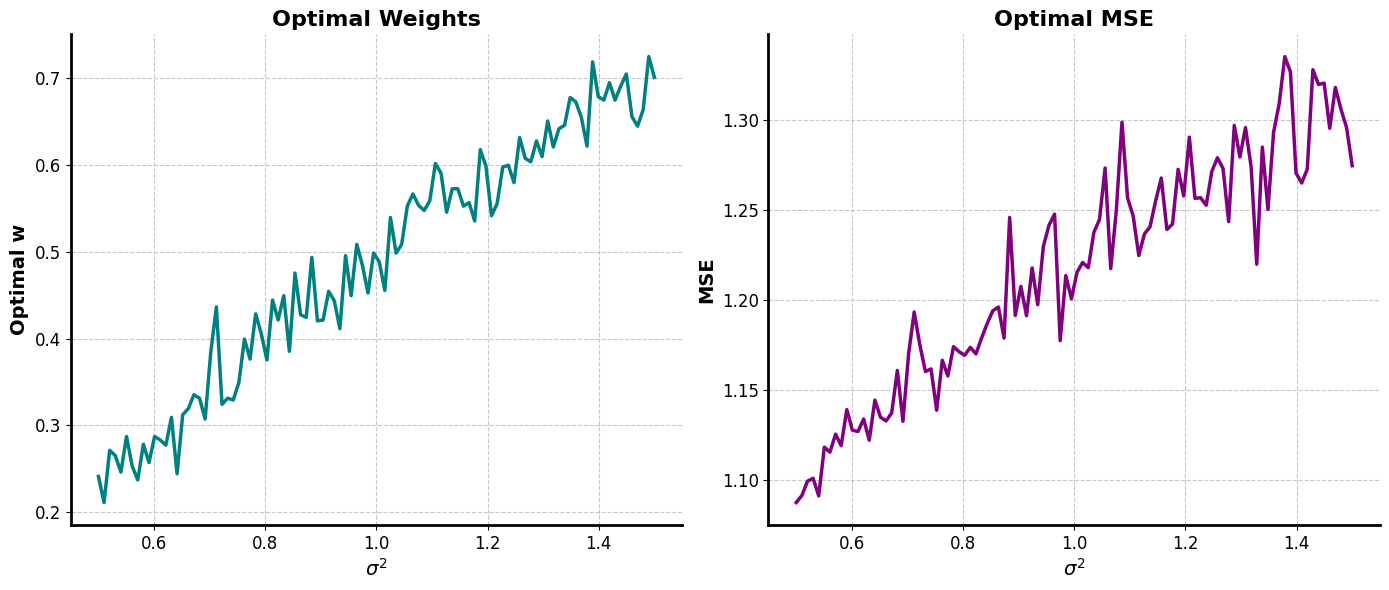

In [21]:
plot_side_by_side(theta_vals, theta_optimal_weights, theta_optimal_mse)


Now we have the inverse effect, where we should rely on the control sample more with bigger batch effects.

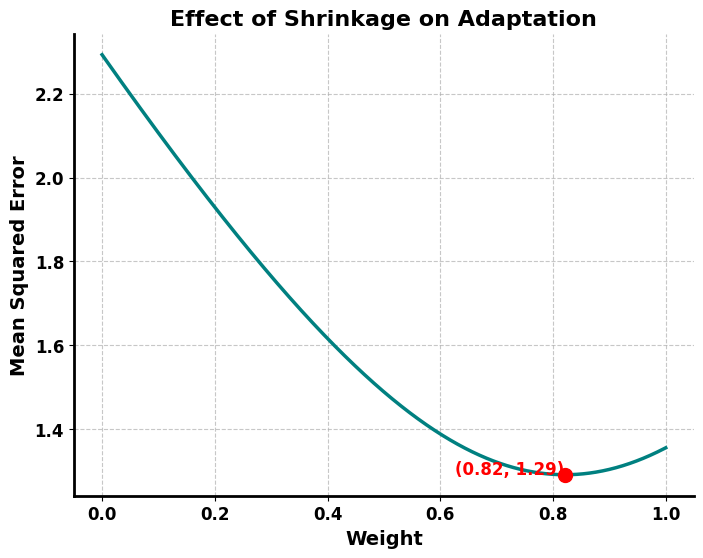

In [23]:
sigma_d=1.0,
sigma_theta=2.0
sigma_epsilon=1.0
n_batches=300
n_samples=150

theta_list,control_list,data_list,delta_list = simulate_single_covariate(n_batches=n_batches,
                                                                         n_samples=n_samples,
                                                                         sigma_d=sigma_d,
                                                                         sigma_theta=sigma_theta,
                                                                         sigma_epsilon=sigma_epsilon)
X_stack = np.concatenate(data_list)
delta_stack = np.concatenate(delta_list)
n_weights = 1000
weight_list = np.linspace(0,1,n_weights)
observed_mse = np.zeros(n_weights)
for j in range(n_weights):
    X_weighted = np.concatenate([data_list[i] - weight_list[j]*control_list[i] for i in range(n_batches)])
    observed_mse[j] = np.sqrt(np.mean((X_weighted-delta_stack)**2))

plot_mse_with_min_point(observed_mse, weight_list)

## Deriving the optimal shrinkage value in terms of $\sigma_\theta^2$ and $\sigma_\epsilon^2$

First let's figure it out numerically

In [26]:
sigma_d=1.0,
sigma_theta=1.0
sigma_epsilon=2.0
n_batches=1000
n_samples=1500

theta_list,control_list,data_list,delta_list = simulate_single_covariate(n_batches=n_batches,
                                                                         n_samples=n_samples,
                                                                         sigma_d=sigma_d,
                                                                         sigma_theta=sigma_theta,
                                                                         sigma_epsilon=sigma_epsilon)

X_stack = np.concatenate(data_list)
delta_stack = np.concatenate(delta_list)

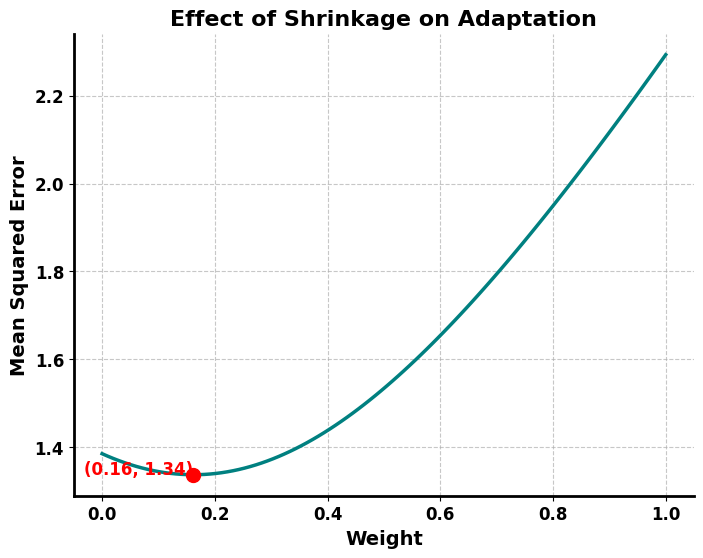

In [27]:
n_weights = 100
weight_list = np.linspace(0,1,n_weights)
observed_mse = np.zeros(n_weights)
for j in range(n_weights):
    X_weighted = np.concatenate([data_list[i] - weight_list[j]*control_list[i] for i in range(n_batches)])
    observed_mse[j] = np.sqrt(np.mean((X_weighted-delta_stack)**2))
plot_mse_with_min_point(observed_mse, weight_list)

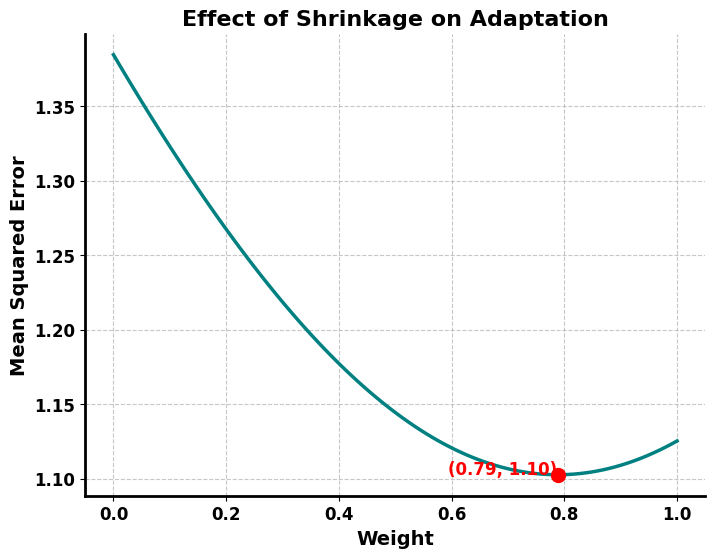

In [28]:
sigma_d=1.0,
sigma_theta=1.0
sigma_epsilon=.5
n_batches=1000
n_samples=1500

theta_list,control_list,data_list,delta_list = simulate_single_covariate(n_batches=n_batches,
                                                                         n_samples=n_samples,
                                                                         sigma_d=sigma_d,
                                                                         sigma_theta=sigma_theta,
                                                                         sigma_epsilon=sigma_epsilon)

X_stack = np.concatenate(data_list)
delta_stack = np.concatenate(delta_list)

n_weights = 100
weight_list = np.linspace(0,1,n_weights)
observed_mse = np.zeros(n_weights)
for j in range(n_weights):
    X_weighted = np.concatenate([data_list[i] - weight_list[j]*control_list[i] for i in range(n_batches)])
    observed_mse[j] = np.sqrt(np.mean((X_weighted-delta_stack)**2))
plot_mse_with_min_point(observed_mse, weight_list)

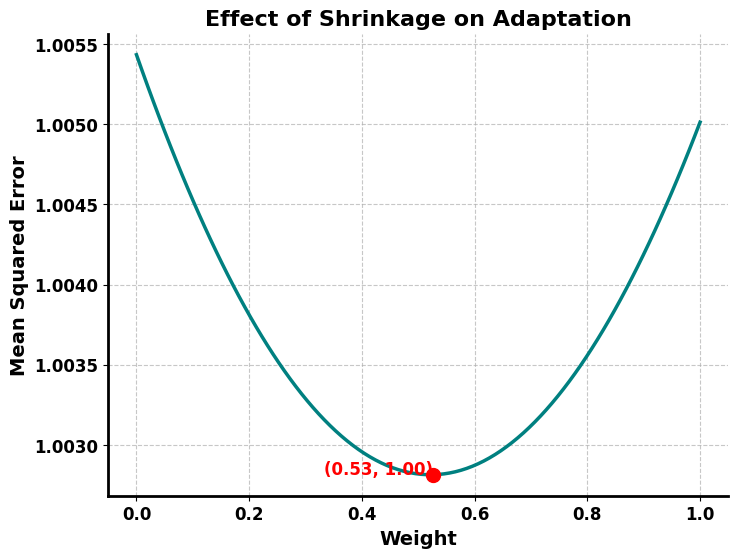

In [37]:
sigma_d=1.0,
sigma_theta=.1
sigma_epsilon=.1
n_batches=1000
n_samples=1500

theta_list,control_list,data_list,delta_list = simulate_single_covariate(n_batches=n_batches,
                                                                         n_samples=n_samples,
                                                                         sigma_d=sigma_d,
                                                                         sigma_theta=sigma_theta,
                                                                         seed=900,
                                                                         sigma_epsilon=sigma_epsilon)

X_stack = np.concatenate(data_list)
delta_stack = np.concatenate(delta_list)

n_weights = 100
weight_list = np.linspace(0,1,n_weights)
observed_mse = np.zeros(n_weights)
for j in range(n_weights):
    X_weighted = np.concatenate([data_list[i] - weight_list[j]*control_list[i] for i in range(n_batches)])
    observed_mse[j] = np.sqrt(np.mean((X_weighted-delta_stack)**2))
plot_mse_with_min_point(observed_mse, weight_list)